# Mining Mobile Phone Reviews

## Step 1 : Defining Required Imports

In [1]:
import re
import nltk
from nltk.corpus import brown
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cross_validation import train_test_split

from collections import Counter

pstemmer = nltk.PorterStemmer()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

## Step 2 : Reading reviews from File

In [2]:
with open('dev_review_data.txt')as f:
    data=f.read().split('\n')
    
for i in range(5):
    print(data[i])
    print("\n")

1|I was very excited when i received the two phones. Fast shipping and everything, however after about two months of using the phones white lines appeared on the screen of both phones which then cost me additional money to replace the screens. Very disappointed since i selected new phones and not used ones for the purpose of avoiding additional cost.|on November 12, 2015|2.0 out of 5 stars


2|The phone I purchased was suppose to be unlocked but it was not. There was a small crack on the screen that was not shown on the picture of the phone. The charger they gave me only lasted for 2 weeks and the worst part was the battery life of the phone. I can only last about 2 hours when the phone is fully charged. Iv'e had an I Phone before purchasing one from them and it would last me the whole day. I recommend you don't buy a phone from this company, or an I Phone at least.|on November 10, 2015|1.0 out of 5 stars


3|It wasn't what I was expected I ordered a new unlocked phone and there was a 

### Step 2.1 : Split Review by '|'

In [3]:
 dictionaryOfData = {}
 for each_review in data:
        temp = each_review.split('|')
        if len(temp) > 1:
            dictionaryOfData[temp[0]] = str(temp[1])
            
dictionaryOfData['1187']

'Not uplook, but other fine. Not not not, recommend, the products because the software dont are uplook in my country'

### Step 2.2 : Normalizing Data

In [4]:
normalizedData = {}
keys = dictionaryOfData.keys()

for key in keys:
    review = dictionaryOfData[key]
    review_as_list_of_sentences = []
    
    for sentence in re.split(r'[.,:;!]', review):
        if sentence:
            sentence = ' '.join([word.lower().strip() for word in sentence.split()])
            review_as_list_of_sentences.append(sentence)
            
    normalizedData[key] = review_as_list_of_sentences

normalizedData['1187']

['not uplook',
 'but other fine',
 'not not not',
 'recommend',
 'the products because the software dont are uplook in my country']

## Step 3 : POS Tagging

In [5]:
# Building backoff tagger for the review data, with specific added training set for 'not'

def build_backoff_tagger_trigram (train_sents):
    t0 = nltk.DefaultTagger("NN")
    t1 = nltk.UnigramTagger(train_sents, backoff = t0)
    t2 = nltk.BigramTagger(train_sents, backoff=t1)
    t3 = nltk.TrigramTagger(train_sents, backoff=t2)
    return t3

sample_sents = brown.tagged_sents(categories=['news', 'editorial', 'reviews'])

addTrainingset = [[('The', 'AT'),  ('battery', 'NN'),  ('is', 'BEZ'),  ('not', 'RB'), ('working', 'VBG'),  ('well', 'RB'), ('.','.')],
                  [('Fast', 'NN'),  ('shipping', 'VBG'),  ('and', 'CC'),  ('everything', 'PN'),  ('however', 'CC'),  ('after', 'IN'),  ('about', 'RB'),  ('two', 'CD'),  ('months', 'NNS'),  ('of', 'IN'),  ('using', 'VBG'),  ('the', 'AT'),  ('phones', 'NNS'), ('white', 'JJ'),  ('lines', 'NNS'),  ('appeared', 'VBD'),  ('on', 'IN'), ('it', 'IN'), ('.','.')],
                  [('The', 'AT'),  ('battery', 'NN'),  ('is', 'BEZ'),  ('not', 'RB'), ('working', 'VBG'),  ('well', 'RB'), ('.','.')],
                  [('After', 'IN'),  ('less', 'AP'),  ('than', 'IN'),  ('six', 'CD'),  ('months', 'NNS'),  ('the', 'AT'),  ('screen', 'NN'), ('is', 'BEZ'),  ('not', 'RB'),  ('working', 'VBG')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('not', 'RB')]
]

#Training the tagger
ngram_tagger = build_backoff_tagger_trigram(sample_sents + addTrainingset + addTrainingset + addTrainingset + addTrainingset)

In [6]:

tagged_dictionaryData = {}
keys = normalizedData.keys()

for key in keys:
    data = normalizedData[key]
    
    temp = []
    
    for sentence in data:
        x = ngram_tagger.tag(nltk.word_tokenize(sentence))
        temp.append(x)
        
    tagged_dictionaryData[key] = temp
    
tagged_dictionaryData['1187']

[[('not', 'RB'), ('uplook', 'NN')],
 [('but', 'CC'), ('other', 'AP'), ('fine', 'JJ')],
 [('not', 'RB'), ('not', '*'), ('not', '*')],
 [('recommend', 'VB')],
 [('the', 'AT'),
  ('products', 'NNS'),
  ('because', 'CS'),
  ('the', 'AT'),
  ('software', 'NN'),
  ('dont', 'NN'),
  ('are', 'BER'),
  ('uplook', 'NN'),
  ('in', 'IN'),
  ('my', 'PP$'),
  ('country', 'NN')]]

### Step 3.1 : Adding some force tags

In [7]:
force_tags = {'not': 'RB', 'however' : 'CC', 'but' : 'CC'}
keys = tagged_dictionaryData.keys()

for key in keys:
    review = tagged_dictionaryData[key]
    temp_review = []
    for sentence in review:
        if sentence:
            sentence = [(word, force_tags.get(word, tag)) for word, tag in sentence]
            temp_review.append(sentence)
            
    tagged_dictionaryData[key] = temp_review
    
    
tagged_dictionaryData['1187']

[[('not', 'RB'), ('uplook', 'NN')],
 [('but', 'CC'), ('other', 'AP'), ('fine', 'JJ')],
 [('not', 'RB'), ('not', 'RB'), ('not', 'RB')],
 [('recommend', 'VB')],
 [('the', 'AT'),
  ('products', 'NNS'),
  ('because', 'CS'),
  ('the', 'AT'),
  ('software', 'NN'),
  ('dont', 'NN'),
  ('are', 'BER'),
  ('uplook', 'NN'),
  ('in', 'IN'),
  ('my', 'PP$'),
  ('country', 'NN')]]

## Step 4 : Remove StopWords

In [8]:
keys = tagged_dictionaryData.keys()

splitData = {}

for key in keys:
    reviewData = tagged_dictionaryData[key]
    reviewDataList = []

    for sentence in reviewData:
        temp = []
        for word, tag in sentence:
            if tag != 'CC':
                temp.append(word)

            else :
                if temp:
                    sent = ' '.join(temp)
                    reviewDataList.append(sent)
                    temp = []

        #Adding the final temp
        sent = ' '.join(temp)
        reviewDataList.append(sent)
        splitData[key] = reviewDataList
        
splitData['1187']

['not uplook',
 'other fine',
 'not not not',
 'recommend',
 'the products because the software dont are uplook in my country']

In [9]:
features={'back': ['processor', 'button', 'camera', 'android', 'back', 'phone', 'nice', 'screen', 'device', 'home', 'time', 'light', 'first', 'smart', 'cell', 'work', 'great', 'i', 'charger', 'best', 'feature', 'case', 'protector', 'small', 'system', 'lock', 'longer', 'good'], 'battery': ['charge', 'year', 'button', 'phone', 'device', 'life', 'home', 'time', 'experience', 'battery', 'light', 'first', 'month', 'few', 'cell', 'day', 'work', 'great', 'charger', 'week', 'hour', 'lock'], 'box': ['apple', 'phone', 'original', 'model', 'product', 'great', 'box', 'button', 'glass', 'cell', 'case', 'lock', 'good'], 'button': ['display', 'button', 'camera', 'android', 'price', 'back', 'phone', 'original', 'device', 'computer', 'store', 'life', 'home', 'time', 'last', 'a', 'battery', 'apple', 'light', 'first', 'condition', 'box', 'cell', 'so', 'inch', 'way', 'deal', 'work', 'product', 'charger', 'same', 'thing', 'lock', 'good'], 'camera': ['processor', 'button', 'camera', 'android', 'back', 'phone', 'nice', 'screen', 'device', 'home', 'time', 'light', 'first', 'smart', 'cell', 'work', 'great', 'i', 'charger', 'best', 'feature', 'case', 'protector', 'small', 'system', 'lock', 'longer', 'good'], 'cell': ['processor', 'button', 'camera', 'android', 'back', 'phone', 'original', 'nice', 'device', 'life', 'home', 'battery', 'light', 'quality', 'smart', 'box', 'headphone', 'cell', 'work', 'great', 'i', 'charger', 'best', 'sound', 'lock', 'good'], 'charger': ['apple', 'phone', 'light', 'work', 'device', 'display', 'computer', 'lock', 'charger', 'button', 'camera', 'life', 'home', 'cell', 'store', 'inch', 'back', 'last', 'battery'], 'connection': ['device', 'connection', 'service', 'delivery', 'seller', 'fast', 'internet', 'system', 'hardware'], 'device': ['charge', 'display', 'button', 'camera', 'glass', 'android', 'back', 'phone', 'device', 'computer', 'screen', 'store', 'life', 'home', 'time', 'last', 'hardware', 'battery', 'brand', 'apple', 'light', 'first', 'cell', 'design', 'inch', 'hand', 'work', 'connection', 'charger', 'internet', 'system', 'protector', 'lock', 'longer'], 'display': ['light', 'model', 'screen', 'display', 'device', 'charger', 'button', 'home', 'protector', 'inch', 'lock', 'longer'], 'hardware': ['apple', 'accessory', 'device', 'connection', 'processor', 'store', 'internet', 'system', 'hardware'], 'headphone': ['phone', 'smart', 'nice', 'work', 'great', 'i', 'headphone', 'best', 'cell', 'android', 'good'], 'home': ['display', 'button', 'camera', 'price', 'back', 'phone', 'device', 'computer', 'store', 'life', 'home', 'last', 'a', 'battery', 'apple', 'light', 'condition', 'cell', 'so', 'inch', 'way', 'deal', 'work', 'product', 'charger', 'same', 'thing', 'lock', 'good'], 'light': ['perfect', 'display', 'button', 'camera', 'back', 'phone', 'device', 'computer', 'store', 'life', 'home', 'carrier', 'last', 'battery', 'order', 'apple', 'light', 'condition', 'cell', 'inch', 'way', 'work', 'great', 'charger', 'lock', 'good'], 'phone': ['bad', 'charge', 'processor', 'review', 'button', 'serial', 'camera', 'android', 'use', 'price', 'back', 'phone', 'original', 'nice', 'star', 'device', 'buy', 'life', 'home', 'time', 'last', 'a', 'experience', 'number', 'battery', 'apple', 'light', 'quality', 'smart', 'condition', 'first', 'box', 'headphone', 'service', 'cell', 'issue', 'so', 'better', 'music', 'couple', 'much', 'way', 'deal', 'work', 'one', 'product', 'great', 'i', 'charger', 'best', 'same', 'thing', 'sound', 'lock', 'feature', 'good'], 'processor': ['apple', 'phone', 'smart', 'nice', 'work', 'great', 'i', 'processor', 'manufacturer', 'best', 'store', 'cell', 'camera', 'android', 'carrier', 'back', 'hardware', 'good'], 'system': ['hardware', 'device', 'connection', 'camera', 'internet', 'design', 'system', 'small', 'back', 'feature']}

## Step 5 : Categorizing reviews under each #feature

In [10]:
reviews_perFeature = {}
for review_id in splitData:
       review_phrases = splitData[review_id]
       for phrase in review_phrases:
           phrase_words = phrase.split(' ')
           set1 = set(phrase_words)
           for term in features:
               set2 = set([term])
               result = set1.intersection(set2)
               if result:
                   if term in reviews_perFeature: 
                       reviews_perFeature[term].append(phrase)
                   else:
                       reviews_perFeature[term] = [phrase]
                        
for i in range(10):
    print(reviews_perFeature['battery'][i])

had to have battery replaced as soon as the phone arrived
another feature that can be troublesome with the iphone 5 is that the battery can not be easily changed out for a new one when it does not hold a charge as well as it once did (
changing the battery voids your warranty )
phones like the galaxy s3 do allow for the capability to change out their batteries so you can have consistent battery power when you need it
phone has many problems the battery is my main problem now not happy about it
i thought it was the battery
the battery was at his 50 %
the battery is not working well
battery lasts about a day
had to pay another 32 dollars for a battery


### Step 5.1 : Converting the above to a Panda Table

In [23]:
df_dict = {}
for aspect in reviews_perFeature:
    tempdict= {}
    tempdict['Text'] = reviews_perFeature[aspect]
    temp_df = pd.DataFrame(tempdict)
    df_dict[aspect] = temp_df
    
df_dict['battery']

,Text
0,had to have battery replaced as soon as the ph...
1,another feature that can be troublesome with t...
2,changing the battery voids your warranty )
3,phones like the galaxy s3 do allow for the cap...
4,phone has many problems the battery is my main...
5,i thought it was the battery
6,the battery was at his 50 %
7,the battery is not working well
8,battery lasts about a day
9,had to pay another 32 dollars for a battery


## Step 6 : Sentiment Analysis

In [13]:
# Fetching the labelled data and training the classifier
train_data_file_name = 'train_data.csv'


train_data_df = pd.read_csv(train_data_file_name, encoding = "ISO-8859-13")
train_data_df.columns = ["Text","Sentiment"]

In [14]:
# Stemming, tokenizing and vectorizing the features
stemmer = pstemmer
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    stems = stem_tokens(tokens, stemmer)
    return stems

# vectorizer = CountVectorizer(
#     analyzer = 'word', # Assigning analyzer as word
#     tokenizer = tokenize,
#     lowercase = True, # Lowercasing the words
#     stop_words = 'english', # For removing stop words from being considered as features
#     ngram_range = (1,3), # Allowing unigrams, bigrams, and trigrams to be considered as features
#     max_features = 50 # Using the top 1000 features
# )

vectorizer = TfidfVectorizer(
    analyzer = 'word',
    min_df=1,
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    ngram_range = (1,3),
    max_features = 1000
)

In [15]:
# Extracting the features from training data
corpus_data_features = vectorizer.fit_transform(train_data_df.Text.tolist())

In [16]:
# Feature to array
corpus_data_features_nd = corpus_data_features.toarray()
corpus_data_features_nd.shape

# Removing features with less than 3 characters
vocab = vectorizer.get_feature_names()
vocab = [word.lower() for word in vocab if len(word) > 2]

In [17]:
# remember that corpus_data_features_nd contains all of our 
# original train and test data, so we need to exclude
# the unlabeled test entries

X_train, X_dev, y_train, y_dev  = train_test_split(
        corpus_data_features_nd, 
        train_data_df.Sentiment,
        train_size=0.99, 
        random_state=1234)

In [18]:
# Training the classifier on the whole training data available
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model = rf_model.fit(X=corpus_data_features_nd, y=train_data_df.Sentiment)

In [19]:
# Performing predictions on the dev set

predictions_dict = {}
for feature in df_dict:
    test_data_df = df_dict[feature]
    corpus_data_features_test_vector = vectorizer.transform(test_data_df.Text.tolist())
    corpus_data_features_test = corpus_data_features_test_vector.toarray()
        
    test_log_pred = rf_model.predict(corpus_data_features_test)
    predictions_dict[feature] = test_log_pred

In [20]:
predictions_dict

{'back': array([ 0,  0,  0,  0, -1, -1, -1,  0, -1,  1,  0,  0,  0,  0,  0,  0, -1,
        -1,  0,  0,  0,  1,  0,  0,  0, -1,  0, -1,  0, -1, -1, -1,  0,  0,
         0,  0, -1,  0,  0, -1,  0, -1,  1,  0, -1,  1, -1,  1,  0,  0, -1,
         0, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1,  0, -1,  0,  1,  0,  0,
         1, -1,  1,  1, -1,  1,  1,  0, -1,  0, -1, -1,  1, -1, -1, -1,  1,
         0]),
 'battery': array([-1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,
        -1,  0, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  1,
        -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,
        -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
        -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,

In [21]:
def plot_Results(predictions_dict):
    # Variables for Product Attributes
    attr_list = []
    
    #Variables for device
    overall_list = []
    
    # Defining dictionaries for storing counts for overall device sentiment
    overall_dict = {'No Of Positive mentions' : 0, 'No Of Negative mentions' : 0}
            
    # Assigning index name to dictionaries for overall counts
    overall_dict['Aspect'] = 'device'
    
    for aspect in predictions_dict:
        if aspect not in ['phone', 'device', 'cell', 'smartphone', 'telephone', 'mobile']:

            # Defining dictionaries for storing counts
            attr_dict = {'No Of Positive mentions' : 0, 'No Of Neutral mentions' : 0, 
                                 'No Of Negative mentions' : 0}
            
            # Assigning index name
            attr_dict['Aspect'] = aspect
            
            # Calculating counts of different sentiments
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            
            # Storing the counts in the dictionaries
            if 1 in count:
                attr_dict['No Of Positive mentions'] = count[1]
                
            if 0 in count:
                attr_dict['No Of Neutral mentions'] = count[0] 
                
            if -1 in count:
                attr_dict['No Of Negative mentions'] = count[-1]
            
            # Appending dictionaries to lists for easier dataframe manipulation
            attr_list.append(attr_dict)
            
        else :
            # Calculating counts of different sentiments for the product
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            
            if 1 in count:
                overall_dict['No Of Positive mentions'] += count[1]
               
            # Commenting out code for the 'maybe' sentiment
#             if 0 in count:
#                 overall_dict['No Of Neutral mentions'] += count[0]
            
            if -1 in count:
                overall_dict['No Of Negative mentions'] += count[-1]
    
    # Appending dictionaries to lists for easier dataframe manipulation
    overall_list.append(overall_dict)

    # For overall product
    df_overall = pd.DataFrame(overall_list)
    df_overall_final= df_overall.set_index('Aspect')
    
    #For printing the re-call table for attributes
    df_attr = pd.DataFrame(attr_list)
    df_attr_final = df_attr.set_index("Aspect")
    
    print("----------------------")
    print("Apsects and number of related phrases")
    print("----------------------")
    
    display(df_attr_final)
    
    print("\n----------------------")
    print("Graph of sentiments for different attributes")
    print("----------------------")
    df_attr_final.plot(kind='bar', color=['r','b','g'],figsize=(12, 10))
    df_attr_final.to_csv('attr_df.csv')
    

----------------------
Apsects and number of related phrases
----------------------


,No Of Negative mentions,No Of Neutral mentions,No Of Positive mentions
Aspect,,,
battery,178,11,25
headphone,2,0,1
box,21,28,17
back,34,39,13
charger,59,27,4
connection,8,1,5
button,22,2,6
hardware,5,12,10
light,4,0,16



----------------------
Graph of sentiments for different attributes
----------------------


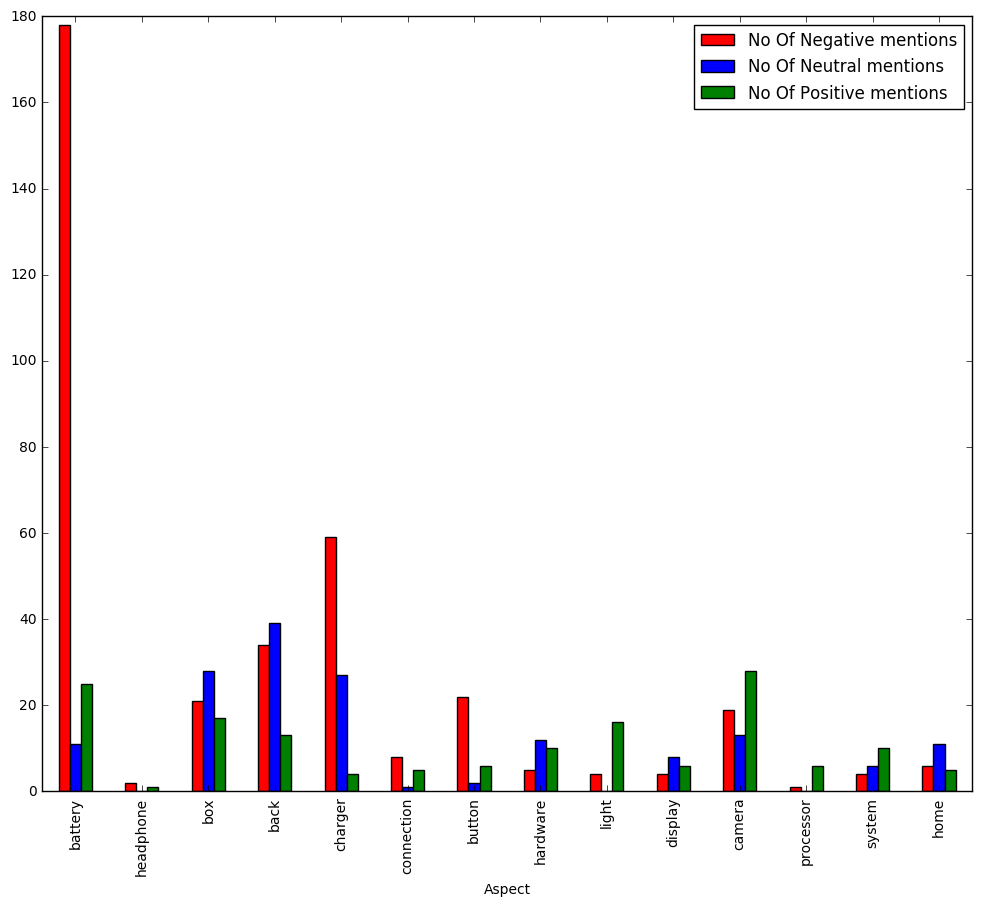

In [22]:
plot_Results(predictions_dict)